# DeepLearning ちょっと横道 その2

## 目的
前回、タイタニック号乗客の生存予測モデルで試したら、全てが同じ値を選択するようになっていたので、モデルを改善する

## タイタニック号乗客の生存予測モデル

### Kaggle
データ解析のSkillを競うCompetitionサイト

### Titanic: Machine Learning from Disaster
https://www.kaggle.com/c/titanic/

参考サイト: タイタニック号乗客の生存予測モデルを立ててみる - Qiita http://qiita.com/suzumi/items/8ce18bc90c942663d1e6

### 今回の方針
層の数を変更することで結果がどう変わるかを見る

![](https://tanaka-tom.github.io/titanic2/3LayerNN.svg)

In [3]:
import pandas as pd
df = pd.read_csv("train.csv").replace("male",0).replace("female",1)

In [72]:
import numpy as np
import sys, os
from collections import OrderedDict
import matplotlib.pyplot as plt

class Affine:
    def __init__(self, W, b):
        self.W = W
        self.b = b
        self.x = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x = x
        out = np.dot(x, self.W) + self.b

        return out

    def backward(self, dout):
        dx = np.dot(dout, self.W.T)
        self.dW = np.dot(self.x.T, dout)
        self.db = np.sum(dout, axis=0)

        return dx
    
class SoftmaxWithLoss:
    def __init__(self):
        self.loss = None
        self.y = None
        self.x = None

    def forward(self, x, t):
        self.t = t
        self.y = softmax(x)
        self.loss = cross_entropy_error(self.y, self.t)

        return self.loss

    def backward(self, dout=1):
        batch_size = self.t.shape[0]
        dx = (self.y - self.t) / batch_size

        return dx

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = (x <= 0)
        out = x.copy()
        out[self.mask] = 0

        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dx = dout

        return dx

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t])) / batch_size

class TwoLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

class ThreeLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, hidden_size) 
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b3'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db

        return grads
    
class FourLayerNet:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, hidden_size) 
        self.params['b2'] = np.zeros(hidden_size)
        self.params['W3'] = weight_init_std * np.random.randn(hidden_size, hidden_size)
        self.params['b3'] = np.zeros(hidden_size)
        self.params['W4'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b4'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])
        self.layers['Relu2'] = Relu()
        self.layers['Affine3'] = Affine(self.params['W3'], self.params['b3'])
        self.layers['Relu3'] = Relu()
        self.layers['Affine4'] = Affine(self.params['W4'], self.params['b4'])

        self.lastLayer = SoftmaxWithLoss()
        
    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        
        return x
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db
        grads['W3'], grads['b3'] = self.layers['Affine3'].dW, self.layers['Affine3'].db
        grads['W4'], grads['b4'] = self.layers['Affine4'].dW, self.layers['Affine4'].db

        return grads

def backprop_learn(x_train, t_train, test_data):
    
    network2 = TwoLayerNet(input_size=6, hidden_size=10, output_size=2)
    network3 = ThreeLayerNet(input_size=6, hidden_size=10, output_size=2)
    network4 = FourLayerNet(input_size=6, hidden_size=10, output_size=2)


    iters_num = 102*100+1
    train_size = x_train.shape[0]
    batch_size = 102
    learning_rate = 0.1

    train_acc_list2 = []
    train_acc_list3 = []
    train_acc_list4 = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    for i in range(iters_num):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grad2 = network2.gradient(x_batch, t_batch)
        grad3 = network3.gradient(x_batch, t_batch)
        grad4 = network4.gradient(x_batch, t_batch)

        for key in ('W1', 'b1', 'W2', 'b2'):
            network2.params[key] -= learning_rate * grad2[key]
        
        for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
            network3.params[key] -= learning_rate * grad3[key]
        
        for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3', 'W4', 'b4'):
            network4.params[key] -= learning_rate * grad4[key]

        if i % iter_per_epoch == 0:
            train_acc2 = network2.accuracy(x_train, t_train)
            train_acc3 = network3.accuracy(x_train, t_train)
            train_acc4 = network4.accuracy(x_train, t_train)
            train_acc_list2.append(train_acc2)
            train_acc_list3.append(train_acc3)
            train_acc_list4.append(train_acc4)
            print(train_acc2, train_acc3, train_acc4)
    predict_data2 = network2.predict(test_data)
    predict_data3 = network3.predict(test_data)
    predict_data4 = network4.predict(test_data)
    
    x = np.arange(0, len(train_acc_list2))
    plt.plot(x, train_acc_list2)
    plt.plot(x, train_acc_list3)
    plt.plot(x, train_acc_list4)
    plt.show()
    
    return np.argmax(predict_data4, axis=1)

In [73]:
import csv

df[["Survived"]]=df[["Survived"]].astype(int)
df2 = df.drop(["PassengerId","Name" , "Ticket", "Cabin", "Embarked"], axis=1).dropna()
train_data = df2.values
x_train = train_data[:, 1:] # Pclass以降の変数
train  = train_data[:, 0]  # 正解データ

t_train = np.zeros((train.shape[0], 2))
t_train[np.arange(train.shape[0]), train.astype(int)] = 1


test_df = pd.read_csv("test.csv").replace("male",0).replace("female",1)
test_df["Age"].fillna(test_df.Age.median(), inplace=True)
test_df["Fare"].fillna(test_df.Fare.median(), inplace=True)

test_df2 = test_df.drop(["PassengerId" ,"Name" , "Ticket" , "Cabin", "Embarked"], axis=1)
test_data = test_df2.values

print(t_train.shape[0])



714


[[  3.       0.      22.       1.       0.       7.25  ]
 [  1.       1.      38.       1.       0.      71.2833]
 [  3.       1.      26.       0.       0.       7.925 ]
 ..., 
 [  1.       1.      19.       0.       0.      30.    ]
 [  1.       0.      26.       0.       0.      30.    ]
 [  3.       0.      32.       0.       0.       7.75  ]] [[ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]
 ..., 
 [ 0.  1.]
 [ 0.  1.]
 [ 1.  0.]]
0.62324929972 0.593837535014 0.593837535014
0.659663865546 0.593837535014 0.593837535014
0.593837535014 0.593837535014 0.593837535014
0.593837535014 0.593837535014 0.593837535014
0.593837535014 0.593837535014 0.593837535014
0.593837535014 0.593837535014 0.593837535014
0.593837535014 0.598039215686 0.593837535014
0.593837535014 0.627450980392 0.593837535014
0.593837535014 0.651260504202 0.593837535014
0.593837535014 0.645658263305 0.593837535014
0.593837535014 0.669467787115 0.593837535014
0.593837535014 0.665266106443 0.593837535014
0.593837535014 0.669467787115 0.59383

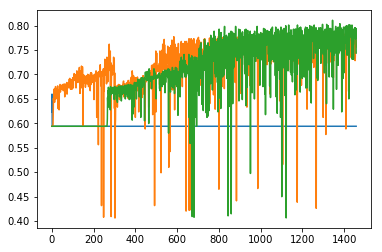

[0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 0 1 1 1 0 0 1 0 0 0 0
 1 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 0 0 1 1 1 1 0 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0 1
 0 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 1 0 0 0 0 1 1 0 0 0
 1 0 1 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 1 0 1 0 0 0 1 0 1 0 1 0 1 0 0 0 0 0 1
 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 0 0 0 1 1 0 1 1 0 1 1 0
 0 1 0 0 1 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 1 0 0 1 0 1 1 0 0 0
 1 0 1 0 1 0 0 1 0 0 0]


In [74]:
print(x_train, t_train)

predict_data = backprop_learn(x_train, t_train, test_data)

print(predict_data)

with open("predict_result_data.csv", "w") as f:
    writer = csv.writer(f, lineterminator='\n')
    writer.writerow(["PassengerId", "Survived"])
    for pid, survived in zip(test_df["PassengerId"].values.astype(int), predict_data.astype(int)):
        writer.writerow([pid, survived])